### Laddar in MNIST och kontrollerar 

In [2]:
# Importerar relevanta bibliotek 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import time
from matplotlib.colors import PowerNorm

import os
import joblib
from datetime import datetime

In [4]:
# Hämtar MNIST datasetet och skriver ut informationen
mnist = fetch_openml("mnist_784", version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

### Kompletterar information genom att googla och läsa bland annat Wikipedia

In [12]:
# Placerar data i X och y samt skriver ut info
X = mnist['data']
y = mnist['target']

print('X shape:', X.shape)
print('y shape:', y.shape)
print('Exempel första 10 y värderna', y[:10])
print('Datatyp X:', X.dtype, '\nDatatyp y:', y.dtype)

X shape: (70000, 784)
y shape: (70000,)
Exempel första 10 y värderna ['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']
Datatyp X: int64 
Datatyp y: object


In [ ]:
# Ändrar y från sträng till int
y = y.astype(np.int64)

# Ändrar storleken på X från int64 till float32 för att floattal funkar bättre med ML modellerna
# Använder float32 istället för float64 som det annars hade blivit om jag bara delat med 255
# float32 tar mindre plats och ger därmed snabbare minne/körningar
X = X.astype(np.float32) / 255.0

print('Efter konvertering:')
print('X min/max', X.min(), X.max())
print('y unika klasser:', np.unique(y))

Efter konvertering:
X min/max 0.0 1.0
y unika klasser: [0 1 2 3 4 5 6 7 8 9]


In [14]:
# Delar i träningsdata och test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=10000,    # Placerar 10 000 i test
    random_state=42,    # Radominerar urvalet
    stratify=y          # Behåller samma klassfördelning på datat i del olika grupperna
)


print('Test:', X_test.shape, y_test.shape)
print('Train:', X_train.shape, y_train.shape)

Test: (10000, 784) (10000,)
Train: (60000, 784) (60000,)


In [15]:
# Kontrollerar klassfördelningen i train och test för att se att stratify fungerar
def class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    pct = np.round(counts / total * 100, 2)
    return dict(zip(unique, zip(counts, pct)))

print('Klassfördelning i y_train (count, %):', class_distribution(y_train))
print('Klassfördelning i y_test  (count, %):', class_distribution(y_test))

Klassfördelning i y_train (count, %): {np.int64(0): (np.int64(5917), np.float64(9.86)), np.int64(1): (np.int64(6752), np.float64(11.25)), np.int64(2): (np.int64(5991), np.float64(9.98)), np.int64(3): (np.int64(6121), np.float64(10.2)), np.int64(4): (np.int64(5849), np.float64(9.75)), np.int64(5): (np.int64(5411), np.float64(9.02)), np.int64(6): (np.int64(5894), np.float64(9.82)), np.int64(7): (np.int64(6251), np.float64(10.42)), np.int64(8): (np.int64(5850), np.float64(9.75)), np.int64(9): (np.int64(5964), np.float64(9.94))}
Klassfördelning i y_test  (count, %): {np.int64(0): (np.int64(986), np.float64(9.86)), np.int64(1): (np.int64(1125), np.float64(11.25)), np.int64(2): (np.int64(999), np.float64(9.99)), np.int64(3): (np.int64(1020), np.float64(10.2)), np.int64(4): (np.int64(975), np.float64(9.75)), np.int64(5): (np.int64(902), np.float64(9.02)), np.int64(6): (np.int64(982), np.float64(9.82)), np.int64(7): (np.int64(1042), np.float64(10.42)), np.int64(8): (np.int64(975), np.float64(9

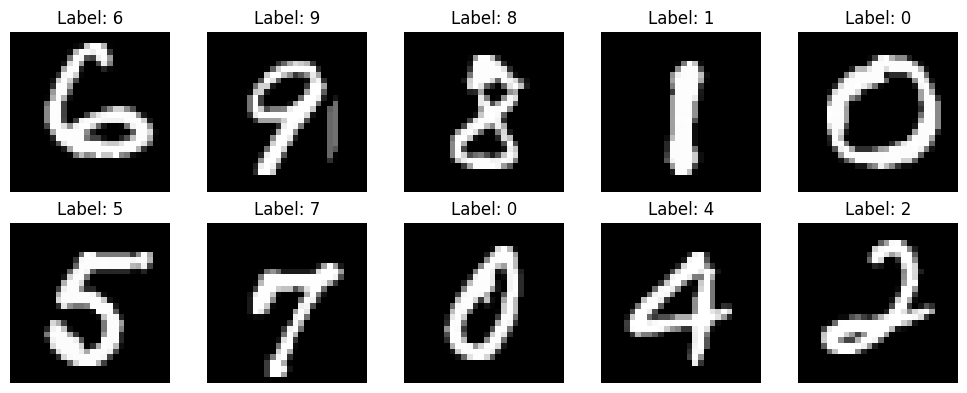

In [16]:
# Visar några exempelbilder från träningsdelen
# Svartvira pixliga bilder som beskrivningen
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for ax, idx in zip(axes.ravel(), range(10)):
    img = X_train[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Baseline
Här väljer jag SGD som baseline för att den är snabb och ger bra referensnivå innan jag provar mer processorkrävande modeller 

In [110]:
# Funderar över 3 eller 5 split. Väljer 5 split även om det tar mer tid att köra, för att få mer stabila resultat
cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'acc': 'accuracy',
    'f1_macro': 'f1_macro',
}

# Funktion för att göra en kryssvalidering skriva ut resultatet från olika modeller
def eval_cv(name, model, X_train, y_train):
    cv_results = cross_validate(
        model, 
        X_train, 
        y_train, 
        cv=cv_grid, 
        scoring=scoring, 
        n_jobs=-1, 
        return_train_score=False
    )
    # Skapar en summering av resultatet och avrundar sifforna något för lättare avläsning av resultatet
    summary = {
        'model': name,
        'accuracy_mean': round(cv_results['test_acc'].mean(), 4),
        'accuracy_std': round(cv_results['test_acc'].std(), 5),
        'f1_macro_mean': round(cv_results['test_f1_macro'].mean(), 4),
        'fit_time_mean_seconds': round(cv_results['fit_time'].mean(), 4),
    }

    return summary

In [109]:
print(cv_search.get_n_splits())          # 5
print(cv_grid.get_n_splits(X_train, y_train)) # 3

3
5


### Jag fick problem med att cv siffran blev ändrad till 3 istället för 5 folds när jag la mer kod. Vissa av av tabellerna nedan visar därför modeller som inte blivit köra ännu eftersom jag har fått köra om kodcellen. Lärdom till nästa gång

In [111]:
# Skapar listan bara om den inte redan finns
if 'models' not in globals():
    models = []

# Modellen redan finns i listan så ersätts den raden samt ger bekräftelse
def upsert_result(models_list, result_dict):
    for i, d in enumerate(models_list):
        if d['model'] == result_dict['model']:
            models_list[i] = result_dict
            print(f"Uppdaterade resultat för '{result_dict['model']}'.")
            return
    models_list.append(result_dict)
    print(f"La till ny modell '{result_dict['model']}'.")

# Dummy baseline
dummy = DummyClassifier(strategy='most_frequent')
upsert_result(models, eval_cv('Dummy(most_frequent)', dummy, X_train, y_train))

# Snabb linjär modell med SGD (Stochastic Gradient Descent)
sgd_logreg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(
        loss='log_loss', # Gör att SGDClassifier optimerar logistisk förlust 
        alpha=1e-4,
        penalty='l2',
        max_iter=1000,
        tol=1e-3,
        early_stopping=True,
        n_iter_no_change=5,
        random_state=42
    ))
])

upsert_result(models, eval_cv('SGDClassifier(log_loss)', sgd_logreg, X_train, y_train))

pd.DataFrame(models).sort_values('accuracy_mean', ascending=False) 

Uppdaterade resultat för 'Dummy(most_frequent)'.
Uppdaterade resultat för 'SGDClassifier(log_loss)'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
14,"PCA40+KNN(k=3,p=2,dist)",0.9761,0.00100,0.9759,1.2448
15,PCA80+SVC(RBF)_tuned,0.9748,0.00060,0.9746,20.8223
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448


In [112]:
# Skapar flera SGD-varianter (olika loss) och utvärderar med CV
sgd_variants = {
    'SGDClassifier(hinge)': 'hinge',
    'SGDClassifier(squared_hinge)': 'squared_hinge',
    'SGDClassifier(modified_huber)': 'modified_huber',
    'SGDClassifier(perceptron)': 'perceptron'
}

for model_name, loss_name in sgd_variants.items():
    sgd_model = Pipeline(steps=[
        ('scaler', StandardScaler()), # Använder StandardScaler för att konvertera snabbare få bättre resultat för hyperparametrar
        ('clf', SGDClassifier(
            loss=loss_name,
            alpha=1e-4,
            penalty='l2',
            max_iter=1000,
            tol=1e-3,
            early_stopping=True,
            n_iter_no_change=5,
            random_state=42
        ))
    ])

    upsert_result(models, eval_cv(model_name, sgd_model, X_train, y_train))

pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)

Uppdaterade resultat för 'SGDClassifier(hinge)'.
Uppdaterade resultat för 'SGDClassifier(squared_hinge)'.
Uppdaterade resultat för 'SGDClassifier(modified_huber)'.
Uppdaterade resultat för 'SGDClassifier(perceptron)'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
14,"PCA40+KNN(k=3,p=2,dist)",0.9761,0.00100,0.9759,1.2448
15,PCA80+SVC(RBF)_tuned,0.9748,0.00060,0.9746,20.8223
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448


### Hinge verkar marginellt bättre och har bra körtid. Testa optimera ytterligare nedan
Skapar en randomisedSearch mall som går att återanvända till optimering av andra modeller

In [ ]:
# Återanvänder samma wrapper för kommande modeller
# Byter då estimator och param_distributions

# CV för sökning. Minskar till 3 split för att snabbsöka
cv_search = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Parameterinställningar för SGD hinge
param_distributions_sgd = {
    # Regualisering. Viktig att söka
    'model__alpha': np.logspace(-6, -2, 25),
    # Regulariseringstyp. Kan påverka både kvalitet och sparsitetsgrad
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    # Endast relevant om penalty='elasticnet'
    'model__l1_ratio': np.linspace(0.0, 1.0, 6),
    # Inlärningsschema
    'model__learning_rate': ['optimal', 'invscaling', 'adaptive', 'constant'],
     # Startstegstorlek. Ignoreras för optimal
    'model__eta0': np.logspace(-4, -1, 10),
    # Kan ibland ge bättre generalisering
    'model__average': [False, True],
    # Konvergens / tid
    'model__max_iter': [1000, 2000],
    'model__tol': np.logspace(-4, -2, 10),
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=sgd_hinge,
    param_distributions=param_distributions_sgd,
    n_iter=25,
    scoring=scoring,
    refit='acc',
    cv=cv_search,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

# Utskrift av bästa inställningarna
i = random_search.best_index_
best_acc = random_search.cv_results_['mean_test_acc'][i]
best_f1  = random_search.cv_results_['mean_test_f1_macro'][i]

print('Best params:', random_search.best_params_)
print(f'Best CV acc: {best_acc:.4f}')
print(f'Best CV f1_macro: {best_f1:.4f}')

best_sgd_hinge = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'model__tol': np.float64(0.003593813663804626), 'model__penalty': 'elasticnet', 'model__max_iter': 2000, 'model__learning_rate': 'optimal', 'model__l1_ratio': np.float64(0.4), 'model__eta0': np.float64(0.004641588833612777), 'model__average': True, 'model__alpha': np.float64(4.641588833612782e-06)}
Best CV acc: 0.9133
Best CV f1_macro: 0.9121


### Verkar som om det blev lite bättre siffra
Arbetar vidare med GridSearch för ytterligare finjustering

In [ ]:
# GridSearch för att göra ett zoomat grid runt de bästa parametrarna från random_search
best_params = random_search.best_params_

# Plockar ut bästa värdena från RandomizedSearch
best_alpha = best_params['model__alpha']
best_penalty = best_params['model__penalty']
best_lr = best_params['model__learning_rate']
best_avg = best_params['model__average']

best_tol = best_params['model__tol']
best_max_iter = best_params['model__max_iter']
best_eta0 = best_params['model__eta0']

# Skapar ett litet grid runt "best" för de viktigaste numeriska parametrarna
param_grid = {
    # Zoomar alpha runt bästa värdet
    'model__alpha': [best_alpha / 3, best_alpha, best_alpha * 3],

    # Zoomar tol runt bästa värdet (påverkar konvergens/hastighet)
    'model__tol': [best_tol / 3, best_tol, best_tol * 3],

    # Låser dessa till bästa valet från RandomizedSearch
    'model__max_iter': [best_max_iter],
    'model__penalty': [best_penalty],
    'model__learning_rate': [best_lr],
    'model__average': [best_avg],

    # Låser eta0 till bästa värdet från RandomizedSearch
    'model__eta0': [best_eta0],
}

# Om elasticnet vann i RandomizedSearch, zoomar vi även l1_ratio runt bästa värdet
if best_penalty == 'elasticnet':
    best_l1_ratio = best_params['model__l1_ratio']
    param_grid['model__l1_ratio'] = [
        max(0.0, best_l1_ratio - 0.1),
        best_l1_ratio,
        min(1.0, best_l1_ratio + 0.1),
    ]

# CV för finjustering. 5 splits för stabilare skattning 
cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV testar alla kombinationer i param_grid
grid_search = GridSearchCV(
    estimator=sgd_hinge, # samma pipeline som i random-söket
    param_grid=param_grid,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Utskrift av bästa inställningarna från grid-söket (både acc och f1_macro)
i = grid_search.best_index_
best_acc = grid_search.cv_results_['mean_test_acc'][i]
best_f1 = grid_search.cv_results_['mean_test_f1_macro'][i]

print('Best params (grid):', grid_search.best_params_)
print(f'Best CV acc (grid): {best_acc:.4f}')
print(f'Best CV f1_macro (grid): {best_f1:.4f}')

best_sgd_hinge_grid = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params (grid): {'model__alpha': np.float64(4.641588833612782e-06), 'model__average': True, 'model__eta0': np.float64(0.004641588833612777), 'model__l1_ratio': np.float64(0.4), 'model__learning_rate': 'optimal', 'model__max_iter': 2000, 'model__penalty': 'elasticnet', 'model__tol': np.float64(0.0011979378879348752)}
Best CV acc (grid): 0.9158
Best CV f1_macro (grid): 0.9147


In [113]:
# Lägger in det bästa resultatet från grid-söket i vår resultatlista
upsert_result(models, eval_cv('SGDClassifier(hinge)', best_sgd_hinge_grid, X_train, y_train))

pd.DataFrame(models).sort_values('accuracy_mean', ascending=False) 

Uppdaterade resultat för 'SGDClassifier(hinge)'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
14,"PCA40+KNN(k=3,p=2,dist)",0.9761,0.00100,0.9759,1.2448
15,PCA80+SVC(RBF)_tuned,0.9748,0.00060,0.9746,20.8223
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448


### Det verkar inte gå att optimera desto mer. Fortsätter med andra modeller

In [ ]:
# ExtraTrees modellen. Ingen scaling behövs
extra_trees = ExtraTreesClassifier(
    n_estimators=300, # Hittade att detta är bättre på nätet men standradinställningen är 100
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Kör korsvalidering på träningsdatan och uppdaterar resultatlistan
upsert_result(models, eval_cv('ExtraTrees', extra_trees, X_train, y_train))

# Visar tabellen sorterad efter accuracy
results_df = pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)
results_df

La till ny modell 'ExtraTrees'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218
4,SGDClassifier(modified_huber),0.9087,0.00014,0.9074,2.9462
3,SGDClassifier(squared_hinge),0.9086,0.00088,0.9074,3.0141
5,SGDClassifier(perceptron),0.9086,0.00051,0.9073,2.9545
0,Dummy(most_frequent),0.1125,0.00002,0.0202,0.1095


### Denna modell verkar lovande
Testar att finjustera men gör först en funktion för att slippa skriva om koden

In [ ]:
# Kommer fram till att det är bättre att göra en funktion för att återanvända randomizedSearch inställningar
def run_random_search(model_name, estimator, param_distributions, X_train, y_train, scoring,
                      cv_search, n_iter=25, refit='acc', random_state=42, verbose=2):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        refit=refit,
        cv=cv_search, # 3 folds för snabb sökning
        n_jobs=-1,
        verbose=verbose,
        random_state=random_state
    )

    random_search.fit(X_train, y_train)

    i = random_search.best_index_
    best_acc = random_search.cv_results_['mean_test_acc'][i]
    best_f1 = random_search.cv_results_['mean_test_f1_macro'][i]

    print(f'RandomizedSearchCV result: {model_name}')
    print('Best params:', random_search.best_params_)
    print(f'Best CV acc: {best_acc:.4f}')
    print(f'Best CV f1_macro: {best_f1:.4f}')

    return random_search, random_search.best_estimator_

In [ ]:
# Parameter 
param_distributions_extra_trees = {
    # Antal träd: fler träd kan ge bättre resultat men tar längre tid
    'n_estimators': [200, 300, 500, 800],
    # Maxdjup: None låter träden växa fritt, medan 20/40/60 begränsar och kan minska överanpassning
    'max_depth': [None, 20, 40, 60],
    # Minsta antal samples för att få splitta en nod. Större värde = mer regularisering
    'min_samples_split': [2, 5, 10],
    # Minsta antal samples i ett blad. Större värde = mer regularisering och ofta bättre generalisering
    'min_samples_leaf': [1, 2, 4],
    # Hur många features som testas vid varje split:
    # 'sqrt' och 'log2' är vanliga och snabba
    # 0.3/0.5/0.7/1.0 testar en andel av features (1.0 = alla)
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, 1.0],
    # Kriterium för split: gini är standard, entropy/log_loss kan ibland ge skillnader
    'criterion': ['gini', 'entropy', 'log_loss'],
    # Bootstrap: True innebär att varje träd tränas på ett bootstrap-sample (kan ibland förbättra)
    'bootstrap': [False, True],
}

# Basestimator. ExtraTrees behöver ingen StandardScaler (trädmodeller är skal-okänsliga).
extra_trees = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# Kör RandomizedSearch med återanvändbar wrapper

random_search_extra_trees, best_extra_trees = run_random_search(
    model_name='ExtraTrees',
    estimator=extra_trees,
    param_distributions=param_distributions_extra_trees,
    X_train=X_train,
    y_train=y_train,
    scoring=scoring,
    cv_search=cv_search,
    n_iter=25, # n_iter=25: antal slumpade kombinationer som testas
    refit='acc'
)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
RandomizedSearchCV result: ExtraTrees
Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': False}
Best CV acc: 0.9699
Best CV f1_macro: 0.9697


### Intressant, det tog ganska lång tid men blev ändå lite sämre resultat
En del av förklarningen är att Randomized är gjord på 3 folds istället för 5 folds. Undersöker om det påverkar.

In [40]:
# Gör körningen av bästa modellen från Randomized med 5 folds
upsert_result(models, eval_cv('ExtraTrees_random_best', best_extra_trees, X_train, y_train))

pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)

Uppdaterade resultat för 'ExtraTrees_random_best'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218
4,SGDClassifier(modified_huber),0.9087,0.00014,0.9074,2.9462
3,SGDClassifier(squared_hinge),0.9086,0.00088,0.9074,3.0141
5,SGDClassifier(perceptron),0.9086,0.00051,0.9073,2.9545
0,Dummy(most_frequent),0.1125,0.00002,0.0202,0.1095


### Randomized är fortfarande sämre plus att den tar längre tid att köra
RandomizedSearchCV tog väldigt lång tid att köra. Jag testar att göra GridSearch i två omgångar. I första låser jag den till etimator 300 för att den inte ska ta så lång tid. Sedan kör jag Gridsearch igen och kollar bara på vilken etimator jag ska ha

In [44]:
# Sök bara de hyperparametrar som påverkar bias/variance mest: (ev. också min_samples_split men den är ofta mindre viktig)
extra_trees_fixed = ExtraTreesClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

# Söker bara de parametrar som ofta ger mest effekt (struktur/regularisering)
param_grid_a = {
    'max_depth': [None, 20, 40],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
}

grid_search_a = GridSearchCV(
    estimator=extra_trees_fixed,
    param_grid=param_grid_a,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search_a.fit(X_train, y_train)

# Utskrift av bästa inställningarna (både acc och f1_macro)
i = grid_search_a.best_index_
best_acc = grid_search_a.cv_results_['mean_test_acc'][i]
best_f1 = grid_search_a.cv_results_['mean_test_f1_macro'][i]

print('Best params (grid A):', grid_search_a.best_params_)
print(f'Best CV acc (grid A): {best_acc:.4f}')
print(f'Best CV f1_macro (grid A): {best_f1:.4f}')

best_extra_trees_a = grid_search_a.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params (grid A): {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
Best CV acc (grid A): 0.9730
Best CV f1_macro (grid A): 0.9728


In [45]:
# Hämtar bästa "struktur"-parametrar från Steg A
best_params_a = grid_search_a.best_params_

# Söker bara på bästa estimator 
extra_trees_structured = ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42,
    max_depth=best_params_a['max_depth'],
    min_samples_leaf=best_params_a['min_samples_leaf'],
    max_features=best_params_a['max_features']
)
# Gör ett relativt tät grid
param_grid_b = {
    'n_estimators': [200, 250, 300, 350, 400, 500]
}

grid_search_b = GridSearchCV(
    estimator=extra_trees_structured,
    param_grid=param_grid_b,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search_b.fit(X_train, y_train)

# Utskrift av bästa inställningarna (både acc och f1_macro)
i = grid_search_b.best_index_
best_acc = grid_search_b.cv_results_['mean_test_acc'][i]
best_f1 = grid_search_b.cv_results_['mean_test_f1_macro'][i]

print('Best params (grid B):', grid_search_b.best_params_)
print(f'Best CV acc (grid B): {best_acc:.4f}')
print(f'Best CV f1_macro (grid B): {best_f1:.4f}')

best_extra_trees_grid = grid_search_b.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params (grid B): {'n_estimators': 500}
Best CV acc (grid B): 0.9732
Best CV f1_macro (grid B): 0.9729


### Det blev lite bättre men ingen större skillnad
Jag vill inte ha en för stor fil för att då får jag svårt att lagra den på Github. Jag vill även ta hänsyn till prestanda och tiden för körningen. 

In [ ]:
# Kontrollerar skillnaden mellan de olika körningarna
results_b = pd.DataFrame(grid_search_b.cv_results_)

cols = [
    'param_n_estimators',
    'mean_test_acc', 
    'std_test_acc',
    'mean_test_f1_macro', 
    'std_test_f1_macro',
    'mean_fit_time'
]

results_b = results_b[cols].sort_values('param_n_estimators')
results_b

,param_n_estimators,mean_test_acc,std_test_acc,mean_test_f1_macro,std_test_f1_macro,mean_fit_time
0,200,0.973067,0.001504,0.972828,0.001497,1704.272656
1,250,0.972950,0.001611,0.972713,0.001600,2111.143715
2,300,0.973000,0.001745,0.972761,0.001744,2487.347204
3,350,0.972917,0.001716,0.972676,0.001715,2703.161882
4,400,0.973033,0.001521,0.972791,0.001506,2782.279994
5,500,0.973167,0.001510,0.972921,0.001512,2762.677628


In [47]:
# Räkna skillnaden mot bästa och se om den är försumbar (< 0.0005)
best_acc = grid_search_b.best_score_  # eftersom refit='acc'
results_b['acc_gap_to_best'] = best_acc - results_b['mean_test_acc']
results_b.sort_values('mean_test_acc', ascending=False)

,param_n_estimators,mean_test_acc,std_test_acc,mean_test_f1_macro,std_test_f1_macro,mean_fit_time,acc_gap_to_best
5,500,0.973167,0.001510,0.972921,0.001512,2762.677628,0.000000
0,200,0.973067,0.001504,0.972828,0.001497,1704.272656,0.000100
4,400,0.973033,0.001521,0.972791,0.001506,2782.279994,0.000133
2,300,0.973000,0.001745,0.972761,0.001744,2487.347204,0.000167
1,250,0.972950,0.001611,0.972713,0.001600,2111.143715,0.000217
3,350,0.972917,0.001716,0.972676,0.001715,2703.161882,0.000250


### Skillanden i toppen 200 vs 500 är minimal
Däremot vet jag 500 är cirka 120 MB och 200 träd är cirka 48 MB. 
Då Github har en filgräns på 100 MB så då väljer jag 200 för min ExtraTree modell

In [49]:
# ExtraTrees med strukturen från Grid A + n_estimators=200
extra_trees_200 = ExtraTreesClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    max_features=0.5
)

# ExtraTrees med strukturen från Grid A + n_estimators=500
extra_trees_500 = ExtraTreesClassifier(
    n_estimators=500,
    n_jobs=-1,
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    max_features=0.5
)

# Uppdaterar tabellen 
upsert_result(models, eval_cv('ExtraTrees_gridA_200', extra_trees_200, X_train, y_train))
upsert_result(models, eval_cv('ExtraTrees_gridA_500', extra_trees_500, X_train, y_train))

pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)

La till ny modell 'ExtraTrees_gridA_200'.
La till ny modell 'ExtraTrees_gridA_500'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218
4,SGDClassifier(modified_huber),0.9087,0.00014,0.9074,2.9462
5,SGDClassifier(perceptron),0.9086,0.00051,0.9073,2.9545
3,SGDClassifier(squared_hinge),0.9086,0.00088,0.9074,3.0141


### Jag ser att de nya modellerna blev marginellt bättre men tar samtidigt betydligt längre tid
Testar att byta tillbaka max_features till 'sqrt' istället för 0.5 pga körtiden

In [50]:
extra_trees_fast_200 = ExtraTreesClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt'   # viktig för hastighet
)

upsert_result(models, eval_cv('ExtraTrees_fast_200', extra_trees_fast_200, X_train, y_train))
pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)

La till ny modell 'ExtraTrees_fast_200'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218
4,SGDClassifier(modified_huber),0.9087,0.00014,0.9074,2.9462
3,SGDClassifier(squared_hinge),0.9086,0.00088,0.9074,3.0141


### Gör ett till riktat test

In [51]:
# max_features='log2'
extra_trees_log2_300 = ExtraTreesClassifier(
    n_estimators=300,
    max_features='log2',
    n_jobs=-1,
    random_state=42
)

upsert_result(models, eval_cv('ExtraTrees_log2_300', extra_trees_log2_300, X_train, y_train))
pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)

La till ny modell 'ExtraTrees_log2_300'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218
4,SGDClassifier(modified_huber),0.9087,0.00014,0.9074,2.9462


### Släpper ExtraTree modellen då jag inte lyckas optimera den ytterligare och går vidare med K-Neighbors

In [ ]:
# KNN-modell 
# KNN är avståndsbaserad så därmed StandardScaler är viktigt
knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        n_jobs=-1
    ))
])

# Kör korsvalidering på träningsdatan och uppdaterar tabell
upsert_result(models, eval_cv('KNN(k=3, distance)', knn, X_train, y_train))

# Visar tabellen sorterad efter accuracy
results_df = pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)
results_df

La till ny modell 'KNN(k=3, distance)'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448
2,SGDClassifier(hinge),0.9090,0.00070,0.9078,2.9430
1,SGDClassifier(log_loss),0.9088,0.00047,0.9075,3.8218


### Verkar fungera bra med 94 % träffsäkerhet
Optimerar med randomized och grid

In [ ]:
# RandomizedSearch
knn_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

param_distributions_knn = {
    # Viktigast: k
    'model__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    # Viktning
    'model__weights': ['uniform', 'distance'],
    # Avstånd (p=1 manhattan, p=2 euclid)
    'model__p': [1, 2],
    # leaf_size påverkar hastighet
    'model__leaf_size': [20, 30, 40, 60]
}

random_search = RandomizedSearchCV(
    estimator=knn_pipe,
    param_distributions=param_distributions_knn,
    n_iter=20,
    scoring=scoring,
    refit='acc',
    cv=cv_search,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

i = random_search.best_index_
best_acc = random_search.cv_results_['mean_test_acc'][i]
best_f1 = random_search.cv_results_['mean_test_f1_macro'][i]

print('Best params:', random_search.best_params_)
print(f'Best CV acc: {best_acc:.4f}')
print(f'Best CV f1_macro: {best_f1:.4f}')

best_knn = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 3, 'model__leaf_size': 40}
Best CV acc: 0.9590
Best CV f1_macro: 0.9587


### Verkar lovande med nästan 96 %
Jag gör en GridSearch utifrån mitt resultat men tar inte med parametrar som gör joblib-filen för stor. 
KNN kan bli mycket långsam i en app, eftersom varje prediktion jämför mot många träningspunkter (i detta fall 70k i slutversionen). Även om jag når 97 % så kan denna bli seg att köra i Streamlit. 
ExtraTrees/SGD är ofta mer “deploy-vänliga”.

### Jag ser att jag missade att ställa in algoritm parametern så att det blev default (auto). Kontrollerar vilken som blev bäst

In [58]:
knn_model = best_knn.named_steps['model']

print('algorithm parameter:', knn_model.algorithm)
print('effective_metric_:', getattr(knn_model, 'effective_metric_', None))
print('effective_metric_params_:', getattr(knn_model, 'effective_metric_params_', None))

# Om en tree-struktur byggdes finns oftast dessa attribut
print('has _tree:', hasattr(knn_model, '_tree'))
print('_tree type:', type(getattr(knn_model, '_tree', None)))

# Om brute används, lagras ibland träningsdatan direkt
print('has _fit_X:', hasattr(knn_model, '_fit_X'))
print('_fit_X shape:', getattr(getattr(knn_model, '_fit_X', None), 'shape', None))

algorithm parameter: auto
effective_metric_: manhattan
effective_metric_params_: {}
has _tree: True
_tree type: <class 'NoneType'>
has _fit_X: True
_fit_X shape: (60000, 784)


### Använder mig av info för att minska mer antalet parametrar till min GridSearch
Output ovan föll på ett brute-liknande läge för Manhattan i 784 dimensioner. Det innebär att jag kan låsa algorithm='brute' och även ta bort leaf_size parametern för att den inte påverkas i brute läget
leaf_size påverkar bara ball_tree/kd_tree. Eftersom _tree är None ovan så är leaf_size bara extra kombinationer utan effekt.

In [59]:
knn_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

# Grid: testar fler k-värden + både p=1 och p=2 + båda viktningar
param_grid_knn = {
    'model__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],
    'model__algorithm': ['brute'], 
}

grid_search_knn = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid_knn,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search_knn.fit(X_train, y_train)

i = grid_search_knn.best_index_
best_acc = grid_search_knn.cv_results_['mean_test_acc'][i]
best_f1 = grid_search_knn.cv_results_['mean_test_f1_macro'][i]

print('Best params (grid):', grid_search_knn.best_params_)
print(f'Best CV acc (grid): {best_acc:.4f}')
print(f'Best CV f1_macro (grid): {best_f1:.4f}')

best_knn_grid = grid_search_knn.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params (grid): {'model__algorithm': 'brute', 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}
Best CV acc (grid): 0.9608
Best CV f1_macro (grid): 0.9605


### Verkar inte gå att få KNN upp till 97 % bara med parametarna. Går vidare och testar PCA (dimensionsreducering)
* PCA sänker dimensionen (784 → t.ex. 40–120 komponenter) ⇒
* ofta bättre accuracy för KNN
* mycket snabbare prediktion (viktigt i Streamlit)
* modellen blir mindre än rå KNN (KNN sparar träningspunkter; med PCA sparas färre features per punkt)

In [61]:
# PCA + KNN pipeline
# - StandardScaler centrerar och skalar
# - PCA med randomized solver är snabbare
# - KNN med brute är stabilt i hög dimension
pca_knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver='randomized', random_state=42)),
    ('model', KNeighborsClassifier(algorithm='brute', n_jobs=-1))
])

param_grid_pca_knn = {
    'pca__n_components': [40, 60, 80, 120],
    'pca__whiten': [False, True],
    'model__n_neighbors': [1, 3, 5],
    'model__p': [1, 2],
    'model__weights': ['distance'],
}

grid_search_pca_knn = GridSearchCV(
    estimator=pca_knn,
    param_grid=param_grid_pca_knn,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search_pca_knn.fit(X_train, y_train)

i = grid_search_pca_knn.best_index_
best_acc = grid_search_pca_knn.cv_results_['mean_test_acc'][i]
best_f1 = grid_search_pca_knn.cv_results_['mean_test_f1_macro'][i]

print('Best params (PCA+KNN):', grid_search_pca_knn.best_params_)
print(f'Best CV acc (PCA+KNN): {best_acc:.4f}')
print(f'Best CV f1_macro (PCA+KNN): {best_f1:.4f}')

best_pca_knn = grid_search_pca_knn.best_estimator_

# Topp 3 kandidater + tid (fit + score) utan att köra om
results = pd.DataFrame(grid_search_pca_knn.cv_results_)
results['mean_total_time'] = results['mean_fit_time'] + results['mean_score_time']

top3 = results.sort_values('mean_test_acc', ascending=False).head(3)[[
    'mean_test_acc', 'std_test_acc',
    'mean_test_f1_macro',
    'mean_fit_time', 'mean_score_time', 'mean_total_time',
    'param_pca__n_components', 'param_pca__whiten',
    'param_model__n_neighbors', 'param_model__p', 'param_model__weights'
]]
top3

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params (PCA+KNN): {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance', 'pca__n_components': 80, 'pca__whiten': False}
Best CV acc (PCA+KNN): 0.9605
Best CV f1_macro (PCA+KNN): 0.9600


,mean_test_acc,std_test_acc,mean_test_f1_macro,mean_fit_time,mean_score_time,mean_total_time,param_pca__n_components,param_pca__whiten,param_model__n_neighbors,param_model__p,param_model__weights
28,0.960467,0.001853,0.960036,2.965450,7.589989,10.555439,80,False,3,2,distance
44,0.959983,0.001885,0.959562,2.857302,7.286511,10.143813,80,False,5,2,distance
24,0.959833,0.002203,0.959382,2.400902,5.015120,7.416022,40,False,3,2,distance


### Det blev ungefär samma med 96 procent och PCA
Verkar bero på StandardScaler före PCA. För MNIST-pixlar kan det förstöra avståndsgeometrin för KNN, eftersom StandardScaler centrerar varje pixel med sin mean (många pixlar är nästan alltid 0),skalar med std (pixlar som sällan är “på” kan få oproportionerligt stor vikt).
KNN på MNIST brukar ofta funka bäst med råa 0–1 pixlar (endast /255.0, ingen per-pixel-standardisering). Då är avståndet mer “bildlikt”.

In [62]:
# Pipeline utan scaler. X är redan /255.0 => 0..1
knn_raw = Pipeline(steps=[
    ('model', KNeighborsClassifier(algorithm='brute', n_jobs=-1))
])

# Litet men rimligt stort grid (32 kombinationer => 32*5 = 160 fits)
param_grid_knn_raw = {
    'model__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],
}

grid_search_knn_raw = GridSearchCV(
    estimator=knn_raw,
    param_grid=param_grid_knn_raw,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search_knn_raw.fit(X_train, y_train)

i = grid_search_knn_raw.best_index_
best_acc = grid_search_knn_raw.cv_results_['mean_test_acc'][i]
best_f1 = grid_search_knn_raw.cv_results_['mean_test_f1_macro'][i]

print('Best params (KNN raw):', grid_search_knn_raw.best_params_)
print(f'Best CV acc (KNN raw): {best_acc:.4f}')
print(f'Best CV f1_macro (KNN raw): {best_f1:.4f}')

best_knn_raw = grid_search_knn_raw.best_estimator_

# Topp 3 + tid (utan omkörning)
results = pd.DataFrame(grid_search_knn_raw.cv_results_)
results['mean_total_time'] = results['mean_fit_time'] + results['mean_score_time']

top3 = results.sort_values('mean_test_acc', ascending=False).head(3)[
    ['mean_test_acc', 'std_test_acc', 'mean_total_time',
     'param_model__n_neighbors', 'param_model__weights', 'param_model__p']
]
top3

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params (KNN raw): {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}
Best CV acc (KNN raw): 0.9724
Best CV f1_macro (KNN raw): 0.9723


,mean_test_acc,std_test_acc,mean_total_time,param_model__n_neighbors,param_model__weights,param_model__p
7,0.972433,0.001873,56.173104,3,distance,2
6,0.971250,0.001992,58.638030,3,uniform,2
11,0.971217,0.002426,52.886405,5,distance,2


### Yes! Den kom upp i 97,2 % när jag tog bort standardScaler
Testar köra om körningen med PCA + kNN men utan StandardScaler. Justera till min tidigare optimering med k= 3

In [64]:
# PCA + KNN på raw pixlar, ingen StandardScaler
pca_knn_raw = Pipeline(steps=[
    ('pca', PCA(svd_solver='randomized', random_state=42)),
    ('model', KNeighborsClassifier(algorithm='brute', n_jobs=-1))
])

# Fokus på några PCA-dimensioner och håller KNN nära min tidigare vinnare (k=3, weights=distance, p=2) för att se om PCA kan ge en boost
param_grid = {
    'pca__n_components': [40, 60, 80, 120, 160],
    'model__n_neighbors': [3],
    'model__weights': ['distance'],
    'model__p': [2]
}

grid_search = GridSearchCV(
    estimator=pca_knn_raw,
    param_grid=param_grid,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

i = grid_search.best_index_
best_acc = grid_search.cv_results_['mean_test_acc'][i]
best_f1 = grid_search.cv_results_['mean_test_f1_macro'][i]

print('Best params (PCA raw + KNN):', grid_search.best_params_)
print(f'Best CV acc: {best_acc:.4f}')
print(f'Best CV f1_macro: {best_f1:.4f}')

# Topp 3 + tid
results = pd.DataFrame(grid_search.cv_results_)
results['mean_total_time'] = results['mean_fit_time'] + results['mean_score_time']
results.sort_values('mean_test_acc', ascending=False).head(3)[
    ['mean_test_acc', 'std_test_acc', 'mean_total_time',
     'param_pca__n_components', 'param_model__n_neighbors']
]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params (PCA raw + KNN): {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance', 'pca__n_components': 40}
Best CV acc: 0.9778
Best CV f1_macro: 0.9776


,mean_test_acc,std_test_acc,mean_total_time,param_pca__n_components,param_model__n_neighbors
0,0.977783,0.001554,8.400826,40,3
1,0.977450,0.001167,9.784375,60,3
2,0.976467,0.001409,9.903657,80,3


### Vilken succe! 97,8 %. En riktigt bra och samtidigt Streamlitvänlig modell
Nu är den rimlig för Streamlit eftersom KNN nu jobbar i 40 dimensioner i stället för 784. Det ger mycket snabbare prediktion och mindre minne. Dessutom riktigt snabb

In [114]:
pca_knn_40 = Pipeline(steps=[
    ('pca', PCA(n_components=40, svd_solver='randomized', random_state=42)),
    ('model', KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        p=2,
        algorithm='brute',
        n_jobs=-1
    ))
])

# Kör korsvalidering på träningsdatan och uppdaterar tabell
upsert_result(models, eval_cv('PCA40+KNN(k=3,p=2,dist)', pca_knn_40, X_train, y_train))

results_df = pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)
results_df

Uppdaterade resultat för 'PCA40+KNN(k=3,p=2,dist)'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
14,"PCA40+KNN(k=3,p=2,dist)",0.9778,0.00155,0.9776,1.4779
15,PCA80+SVC(RBF)_tuned,0.9748,0.00060,0.9746,20.8223
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448


### Jag tror inte att det är sant. 1,48 sekunder i körtid men samtidigt min bäst presterande modell med F1 = 97,76 %
Hoppas det håller i sig till träningsdatan. Testar en SVC modell som jämförelse

In [72]:
# Delmängd av alla data till att börja med (10 000 av 60 000) 
X_svc = X_train[:10000]
y_svc = y_train[:10000]

svc_rbf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', C=5.0, gamma='scale'))
])

res = cross_validate(
    svc_rbf,
    X_svc, y_svc,
    cv=cv_grid,
    scoring={'acc': 'accuracy'},
    n_jobs=-1
)

print('RBF-SVC (5-fold) on', len(X_svc), 'samples')
print('acc_mean:', np.mean(res['test_acc']).round(4), 'acc_std:', np.std(res['test_acc']).round(4))
print('fit_time_mean_s:', np.mean(res['fit_time']).round(2))
print('score_time_mean_s:', np.mean(res['score_time']).round(2))

RBF-SVC (5-fold) on 10000 samples
acc_mean: 0.9424 acc_std: 0.0042
fit_time_mean_s: 18.88
score_time_mean_s: 5.54


In [73]:
svc_rbf_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=80, svd_solver='randomized', random_state=42)),
    ('model', SVC(kernel='rbf', C=5.0, gamma='scale'))
])

res = cross_validate(
    svc_rbf_pca,
    X_svc, y_svc,
    cv=cv_grid,
    scoring={'acc': 'accuracy'},
    n_jobs=-1
)

print('PCA(80)+RBF-SVC (5-fold) on', len(X_svc), 'samples')
print('acc_mean:', np.mean(res['test_acc']).round(4), 'acc_std:', np.std(res['test_acc']).round(4))
print('fit_time_mean_s:', np.mean(res['fit_time']).round(2))
print('score_time_mean_s:', np.mean(res['score_time']).round(2))

PCA(80)+RBF-SVC (5-fold) on 10000 samples
acc_mean: 0.9549 acc_std: 0.0053
fit_time_mean_s: 1.29
score_time_mean_s: 0.47


### Hyfsat bra siffor även om jag inte tränar på hela datasetet med SVC. Testar optimera SVC med PCA


In [76]:
svc_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=80, svd_solver='randomized', random_state=42)),
    ('model', SVC(kernel='rbf'))
])

param_distributions = {
    'model__C': np.logspace(-1, 2, 15),          # 0.1 .. 100
    'model__gamma': np.logspace(-4, -1, 15)      # 1e-4 .. 1e-1
}

random_search = RandomizedSearchCV(
    estimator=svc_pca,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_svc, y_svc)

print('Best params (random):', random_search.best_params_)
print('Best CV acc (random):', round(random_search.best_score_, 4))

best_svc_pca_random = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (random): {'model__gamma': np.float64(0.0011787686347935866), 'model__C': np.float64(61.054022965853264)}
Best CV acc (random): 0.9529


In [79]:
best = random_search.best_params_
best_C = best['model__C']
best_gamma = best['model__gamma']

param_grid = {
    'model__C': [best_C/3, best_C, best_C*3],
    'model__gamma': [best_gamma/3, best_gamma, best_gamma*3],
}

grid_search = GridSearchCV(
    estimator=svc_pca,
    param_grid=param_grid,
    scoring=scoring,
    refit='acc',
    cv=cv_grid,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_svc, y_svc)

print('Best params (grid):', grid_search.best_params_)
print('Best CV acc (grid):', round(grid_search.best_score_, 4))

best_svc_pca_grid = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params (grid): {'model__C': np.float64(20.351340988617753), 'model__gamma': np.float64(0.0011787686347935866)}
Best CV acc (grid): 0.9537


In [ ]:
# Träna om slutmodellen av SVC på hela träningsdatan 60 000, istället för 10 000
best_svc_pca_grid.fit(X_train, y_train); 

In [115]:
# Lägger till SVC-modellen i listan 
upsert_result(models, eval_cv('PCA80+SVC(RBF)_tuned', best_svc_pca_grid, X_train, y_train))

# Visar tabellen sorterad efter accuracy
results_df = pd.DataFrame(models).sort_values('accuracy_mean', ascending=False)
results_df

Uppdaterade resultat för 'PCA80+SVC(RBF)_tuned'.


,model,accuracy_mean,accuracy_std,f1_macro_mean,fit_time_mean_seconds
14,"PCA40+KNN(k=3,p=2,dist)",0.9778,0.00155,0.9776,1.4779
15,PCA80+SVC(RBF)_tuned,0.9766,0.00161,0.9764,29.7245
10,ExtraTrees_gridA_500,0.9716,0.00116,0.9714,630.7196
9,ExtraTrees_gridA_200,0.9713,0.00088,0.9711,230.7058
6,ExtraTrees,0.9711,0.00122,0.9709,28.1123
7,ExtraTrees_baseline_300,0.9711,0.00122,0.9709,28.8152
11,ExtraTrees_fast_200,0.9702,0.00106,0.9700,18.9775
8,ExtraTrees_random_best,0.9699,0.00066,0.9697,41.4634
12,ExtraTrees_log2_300,0.9676,0.00038,0.9673,11.9082
13,"KNN(k=3, distance)",0.9436,0.00055,0.9430,0.4448


### PCA40+KNN gav bäst resultat samtidigt som modellen är snabb och lätt att använda i en interaktiv app som Streamlit. PCA minskar dimensionsantalet och gör KNN praktiskt för Streamlit utan att offra noggrannhet.
RBF-SVC presterade bra men var betydligt mer tidskrävande. Eftersom PCA40+KNN både var snabbare och gav högre accuracy valde jag den.
ExtraTrees ligger runt 97,1 % , dvs lite sämre nogrannhet och vissa varianter blir extremt långsamma. Därför faller valet på kNN. 

### Gör OOF (out of fold) och confusion matrix för kontroll

In [ ]:
def plot_confusion_suite(y_true, y_pred, labels=None, figsize_errors=(7, 5.5), figsize_norm=(6.5, 5.0)):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))

    # 1) Endast fel: diagonalen sätts till 0 och zoomar in med vmax för att små fel ska synas bättre
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0.0)

    off_diag_max = float(cm_errors.max())
    vmax = max(0.03, off_diag_max)   # minst 3% eller max-fel
    vmax = min(vmax, 0.20)           # säkerhetsgräns

    fig, ax = plt.subplots(figsize=figsize_errors)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_errors, display_labels=labels)
    disp.plot(
        ax=ax,
        cmap='magma',
        colorbar=True,
        values_format='.3f',
        im_kw={'vmin': 0.0, 'vmax': vmax},
        text_kw={'fontsize': 9}
    )
    ax.set_title('Confusion matrix (errors only)')
    plt.tight_layout()
    plt.show()

    # 2) Normaliserad confusion matrix med kontrast (PowerNorm förstärker små värden)
    fig, ax = plt.subplots(figsize=figsize_norm)
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=labels,
        normalize='true',
        values_format='.2f',
        cmap='Blues',
        ax=ax,
        colorbar=True,
        im_kw={'norm': PowerNorm(gamma=0.3)},
        text_kw={'fontsize': 9}
    )
    ax.set_title('Confusion matrix (normalized)')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0     0.9884    0.9926    0.9905      5917
           1     0.9818    0.9923    0.9870      6752
           2     0.9806    0.9790    0.9798      5991
           3     0.9757    0.9647    0.9702      6121
           4     0.9831    0.9747    0.9789      5849
           5     0.9744    0.9706    0.9725      5411
           6     0.9804    0.9917    0.9860      5894
           7     0.9724    0.9797    0.9760      6251
           8     0.9796    0.9612    0.9703      5850
           9     0.9612    0.9690    0.9651      5964

    accuracy                         0.9778     60000
   macro avg     0.9778    0.9775    0.9776     60000
weighted avg     0.9778    0.9778    0.9778     60000



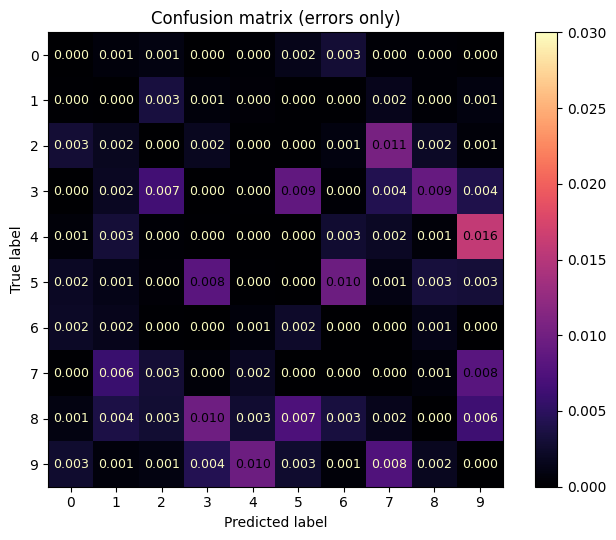

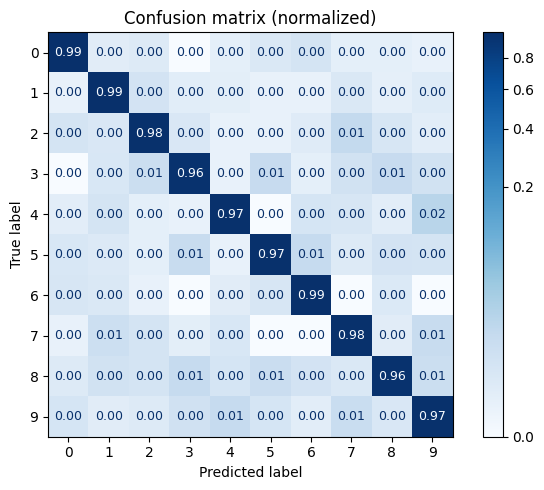

In [ ]:
# Confusion matrix för felanalys

# 5-fold OOF på TRAIN (60k)
cv_oof = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_oof = cross_val_predict(
    pca_knn_40,
    X_train, y_train,
    cv=cv_oof,
    n_jobs=-1
)

print(classification_report(y_train, y_pred_oof, digits=4))
plot_confusion_suite(y_train, y_pred_oof, labels=np.arange(10))

### Verkar som att det främsta felet är att den tolkar fyror som nia

### Tränar kNN på hela träningssetet, utvärderar mot test samt gör confusion matrix

Test accuracy: 0.9763
              precision    recall  f1-score   support

           0     0.9859    0.9949    0.9904       986
           1     0.9808    0.9964    0.9885      1125
           2     0.9888    0.9730    0.9808       999
           3     0.9752    0.9657    0.9704      1020
           4     0.9843    0.9621    0.9730       975
           5     0.9755    0.9723    0.9739       902
           6     0.9779    0.9898    0.9838       982
           7     0.9714    0.9770    0.9742      1042
           8     0.9812    0.9610    0.9710       975
           9     0.9431    0.9678    0.9553       994

    accuracy                         0.9763     10000
   macro avg     0.9764    0.9760    0.9761     10000
weighted avg     0.9764    0.9763    0.9763     10000



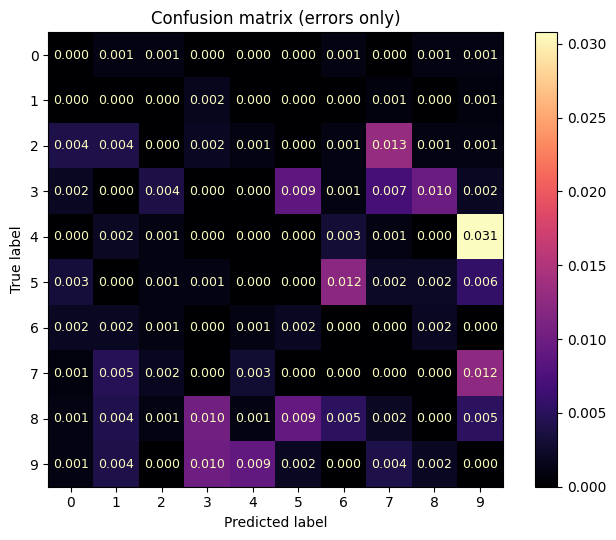

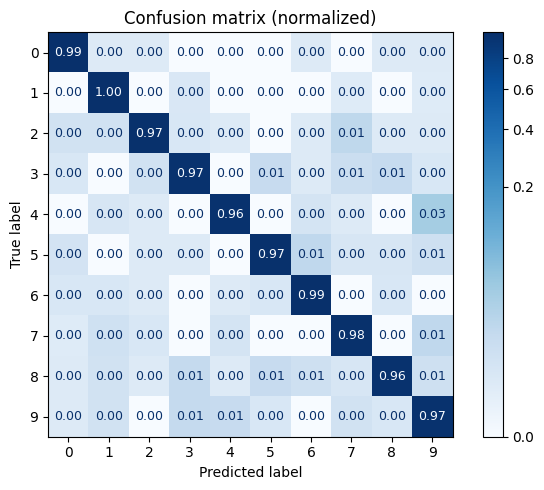

In [118]:
# Träna på hela träningssetet (60k)
pca_knn_40.fit(X_train, y_train)

# Utvärdera på test (10k) 
y_test_pred = pca_knn_40.predict(X_test)

print('Test accuracy:', round(accuracy_score(y_test, y_test_pred), 5))
print(classification_report(y_test, y_test_pred, digits=4))

# confusion matrix på test
plot_confusion_suite(y_test, y_test_pred, labels=np.arange(10))

### Fortfarande 4 som tolkas som 9:or som är främsta felkällan

### Tränar min deploy modell på hela datasetet inför Streamlit

In [94]:
# Lägger ihop tränings och testdatan igen och staplar dem på varandra för alla bilder
X_all = np.vstack([X_train, X_test])
# Lägger ihop träning+test för ettiketterna (0-9)
y_all = np.concatenate([y_train, y_test])

# Tränar på hela datasetet
pca_knn_40.fit(X_all, y_all)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pca', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",40
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.lin

### Spara med joblib + kontrollera filstorlek

In [97]:
# Skapar en katalog för att spara modellen, om den inte redan finns
os.makedirs('models', exist_ok=True)

# Spara hela pipelinen (PCA + KNN) i en joblib-fil. Komprimerar med nivå 3 för att minska storleken utan att det tar för lång tid att spara/ladda.
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"models/PCA40_KNN_k3_p2_distance_{timestamp}.joblib"
joblib.dump(pca_knn_40, model_path) 

# Efter att ha sparat modellen, kan vi kontrollera filstorleken för att se hur stor den är
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f'Saved: {model_path} ({size_mb:.2f} MB)')

Saved: models/PCA40_KNN_k3_p2_distance_20260223_001824.joblib (11.34 MB)


In [98]:
# Listar alla sparade modeller i 'models'-katalogen och visar deras storlek i MB
for fn in sorted(os.listdir('models')):
    p = os.path.join('models', fn)
    if os.path.isfile(p):
        print(f'{fn:45s} {os.path.getsize(p)/(1024*1024):8.2f} MB')

ExtraTrees_20260219_120852.joblib               787.83 MB
KNN_k_3__distance__20260219_121605.joblib       164.93 MB
PCA40_KNN_k3_p2_distance_20260223_001454.joblib    10.15 MB
PCA40_KNN_k3_p2_distance_20260223_001516.joblib    10.15 MB
PCA40_KNN_k3_p2_distance_20260223_001824.joblib    11.34 MB
